This is the notebook for the Car-Net project. The notebook allows the user to reproduce the results of the project. Details of the project can be found here. The notebook will download the dataset, move files to the correct directories, pre-process the data, and train a deep learning model to be able to predict the make of a car from its image. If you simply would like to use the pre-trained model to predict on your own images, please skip to the final section titled "The Ultimate Test". 

# Data Preparation

This section preprocesses the Cars Dataset so that it can be used to train our deep learning model on the task of predicting the make of a car.

Download the data files from the [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) and extract them in this directory. 

In [1]:
!mkdir cardata && wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2018-07-04 20:32:21--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   761KB/s    in 0.4s    

2018-07-04 20:32:22 (761 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [0]:
!tar -xzf car_devkit.tgz

In [0]:
!mv devkit cardata/

In [4]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2018-07-04 20:32:32--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  26.1MB/s    in 38s     

2018-07-04 20:33:10 (24.7 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [0]:
!tar -xzf cars_train.tgz

In [0]:
!mv cars_train/ cardata/

In [7]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz

--2018-07-04 20:33:35--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  25.9MB/s    in 35s     

2018-07-04 20:34:10 (27.0 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [0]:
!tar -xzf cars_test.tgz

In [0]:
!mv cars_test/ cardata/

In [10]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat

--2018-07-04 20:35:07--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat’

cars_test_annos_wit 100%[===================>] 181.40K   257KB/s    in 0.7s    

2018-07-04 20:35:08 (257 KB/s) - ‘cars_test_annos_withlabels.mat’ saved [185758/185758]



In [0]:
!mv cars_test_annos_withlabels.mat cardata/devkit/

## Creating Classes for Our Data

In [1]:
import scipy.io
import numpy as np
import os

The data set comes with a development kit that tells us the class labels and the label of each image. The original data set classifies each image by make, model, and year. However in this task, we want to make a model that can only classify the make of the car (e.g. BMW,Honda...etc.)

The list of classes is given in a MATLAB array inside the devkit folder. So we use scipy to load the array into Python

In [2]:
PATH = "data/cars/"

In [4]:
files = os.listdir(f'{PATH}')
files

['tmp',
 'devkit',
 'cars_test',
 'models',
 '1512.03385.pdf',
 'plots',
 'cars_train',
 '3drr13.pdf',
 'train.csv']

In [6]:
!ls data/cars/devkit/

cars_annos.mat	     cars_test_annos_withlabels.mat  README.txt
cars_meta.mat	     cars_train_annos.mat	     train_perfect_preds.txt
cars_test_annos.mat  eval_train.m


In [7]:
classes_matlab = scipy.io.loadmat(f'{PATH}devkit/cars_meta.mat')

Let's check the type of the variable that has the loaded MATLAB array

In [8]:
type(classes_matlab)

dict

In [9]:
classes_matlab.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [10]:
classes_matlab['class_names'].shape

(1, 196)

Okay, so we can tell from the information above that the variable is a dictionary. The classes are grouped in an array under the key 'class_names'. The class labels cover the make, model, and year of each car. So we must create another list of class labels that cover only the make of the car.

In [11]:
class_names = classes_matlab['class_names'][0]

In [12]:
class_names[90]

array(['Dodge Dakota Club Cab 2007'], dtype='<U26')

Here we will group all the class labels based on the make of the car.

In [13]:
car_make_list = []
for class_name in class_names:
    car_make = class_name[0].split()[0] #grab the first word in the label (i.e. the car make)
    if car_make not in car_make_list: #add car make to the list if doesn't already exist
        car_make_list.append(car_make)
    else:
        continue

In [14]:
car_make_list[:5]

['AM', 'Acura', 'Aston', 'Audi', 'BMW']

In [15]:
len(car_make_list)

49

Now we have a list of all the different makes of the cars in our data, regardless of their model or year. Great! 

## Re-labelling our Data

### Training Set

In [16]:
train_annots_mat = scipy.io.loadmat(f'{PATH}devkit/cars_train_annos.mat')

In [17]:
type(train_annots_mat)

dict

In [18]:
train_annots_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [19]:
train_annots_mat['annotations'][0][2]

(array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))

In [20]:
#max_id = 1000
#for annot in train_annots_mat['annotations'][0]:
#    label_id = annot[4][0][0]
#    max_id = min(max_id, label_id)
#print(max_id)

In [21]:
train_annots_mat['annotations'].shape

(1, 8144)

In [22]:
train_annots_mat['annotations'][0][7][4][0][0]

96

Next we need to create a .csv file containing the name and label of each image in the training set before we can start building our model. 

In [23]:
train_annots = train_annots_mat['annotations'][0]

imgs_labels = []

for img_annots in train_annots:
    img_name = img_annots[5][0]
    img_label_id = img_annots[4][0][0]
    img_label = class_names[img_label_id-1][0].split()[0]
    imgs_labels.append([img_name, img_label])
print(imgs_labels)
    

[['00001.jpg', 'Audi'], ['00002.jpg', 'Acura'], ['00003.jpg', 'Dodge'], ['00004.jpg', 'Hyundai'], ['00005.jpg', 'Ford'], ['00006.jpg', 'Geo'], ['00007.jpg', 'Dodge'], ['00008.jpg', 'Dodge'], ['00009.jpg', 'Mitsubishi'], ['00010.jpg', 'Chevrolet'], ['00011.jpg', 'Buick'], ['00012.jpg', 'Toyota'], ['00013.jpg', 'Hyundai'], ['00014.jpg', 'Dodge'], ['00015.jpg', 'Volvo'], ['00016.jpg', 'Plymouth'], ['00017.jpg', 'Audi'], ['00018.jpg', 'Chevrolet'], ['00019.jpg', 'Volkswagen'], ['00020.jpg', 'Chevrolet'], ['00021.jpg', 'Chrysler'], ['00022.jpg', 'BMW'], ['00023.jpg', 'GMC'], ['00024.jpg', 'Nissan'], ['00025.jpg', 'Volvo'], ['00026.jpg', 'Hyundai'], ['00027.jpg', 'Suzuki'], ['00028.jpg', 'Dodge'], ['00029.jpg', 'Spyker'], ['00030.jpg', 'Volvo'], ['00031.jpg', 'Land'], ['00032.jpg', 'Hyundai'], ['00033.jpg', 'Chevrolet'], ['00034.jpg', 'Hyundai'], ['00035.jpg', 'Land'], ['00036.jpg', 'Ferrari'], ['00037.jpg', 'BMW'], ['00038.jpg', 'Dodge'], ['00039.jpg', 'Fisker'], ['00040.jpg', 'Infiniti'], 

In [24]:
header = 'imagename,label'
with open(f'{PATH}train.csv', 'w') as f:
    f.write(header)
    f.write('\n')
    for sample in imgs_labels:
        f.write(sample[0]+','+sample[1])
        f.write('\n')

In [25]:
!wc -l cardata/train.csv

wc: cardata/train.csv: No such file or directory


In [27]:
!head data/cars/train.csv

imagename,label
00001.jpg,Audi
00002.jpg,Acura
00003.jpg,Dodge
00004.jpg,Hyundai
00005.jpg,Ford
00006.jpg,Geo
00007.jpg,Dodge
00008.jpg,Dodge
00009.jpg,Mitsubishi


### Test Set

In [28]:
test_annots_mat = scipy.io.loadmat(f'{PATH}devkit/cars_test_annos_withlabels.mat')

In [29]:
type(test_annots_mat)

dict

In [30]:
test_annots_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [31]:
test_annots_mat['annotations'][0][2]

(array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))

In [32]:
test_annots_mat['annotations'].shape

(1, 8041)

In [33]:
test_annots_mat['annotations'][0][7][4][0][0]

165

Next we need to create a .csv file containing the name and label of each image in the test set before we can start building our model. 

In [34]:
test_annots = test_annots_mat['annotations'][0]

test_imgs_labels = []

for img_annots in test_annots:
    test_img_name = img_annots[5][0]
    test_img_label_id = img_annots[4][0][0]
    test_img_label = class_names[test_img_label_id-1][0].split()[0]
    test_imgs_labels.append([test_img_name, test_img_label])
print(test_imgs_labels)

[['00001.jpg', 'Suzuki'], ['00002.jpg', 'Ferrari'], ['00003.jpg', 'Jeep'], ['00004.jpg', 'Toyota'], ['00005.jpg', 'Tesla'], ['00006.jpg', 'Chrysler'], ['00007.jpg', 'GMC'], ['00008.jpg', 'Mercedes-Benz'], ['00009.jpg', 'BMW'], ['00010.jpg', 'Chevrolet'], ['00011.jpg', 'Buick'], ['00012.jpg', 'Ford'], ['00013.jpg', 'Ford'], ['00014.jpg', 'Hyundai'], ['00015.jpg', 'Dodge'], ['00016.jpg', 'Cadillac'], ['00017.jpg', 'Land'], ['00018.jpg', 'BMW'], ['00019.jpg', 'Audi'], ['00020.jpg', 'BMW'], ['00021.jpg', 'Lamborghini'], ['00022.jpg', 'Acura'], ['00023.jpg', 'Chrysler'], ['00024.jpg', 'Ford'], ['00025.jpg', 'Mercedes-Benz'], ['00026.jpg', 'Volkswagen'], ['00027.jpg', 'Nissan'], ['00028.jpg', 'Volvo'], ['00029.jpg', 'Dodge'], ['00030.jpg', 'Acura'], ['00031.jpg', 'Mercedes-Benz'], ['00032.jpg', 'Jeep'], ['00033.jpg', 'Toyota'], ['00034.jpg', 'Bentley'], ['00035.jpg', 'BMW'], ['00036.jpg', 'Acura'], ['00037.jpg', 'BMW'], ['00038.jpg', 'Chevrolet'], ['00039.jpg', 'BMW'], ['00040.jpg', 'Mercede

In [35]:
len(test_imgs_labels)

8041

In [36]:
test_imgs_labels[8040]

['08041.jpg', 'BMW']

In [37]:
header = 'imagename,label'
with open(f'{PATH}test.csv', 'w') as f:
    f.write(header)
    f.write('\n')
    for sample in test_imgs_labels:
        f.write(sample[0]+','+sample[1])
        f.write('\n')

In [38]:
!wc -l data/cars/test.csv

8042 data/cars/test.csv


In [40]:
!head data/cars/test.csv

imagename,label
00001.jpg,Suzuki
00002.jpg,Ferrari
00003.jpg,Jeep
00004.jpg,Toyota
00005.jpg,Tesla
00006.jpg,Chrysler
00007.jpg,GMC
00008.jpg,Mercedes-Benz
00009.jpg,BMW


In [41]:
label_encodings = {}

In [42]:
for idx, label in enumerate(car_make_list):
  label_encodings[label] = idx

In [43]:
label_encodings

{'AM': 0,
 'Acura': 1,
 'Aston': 2,
 'Audi': 3,
 'BMW': 4,
 'Bentley': 5,
 'Bugatti': 6,
 'Buick': 7,
 'Cadillac': 8,
 'Chevrolet': 9,
 'Chrysler': 10,
 'Daewoo': 11,
 'Dodge': 12,
 'Eagle': 13,
 'FIAT': 14,
 'Ferrari': 15,
 'Fisker': 16,
 'Ford': 17,
 'GMC': 18,
 'Geo': 19,
 'HUMMER': 20,
 'Honda': 21,
 'Hyundai': 22,
 'Infiniti': 23,
 'Isuzu': 24,
 'Jaguar': 25,
 'Jeep': 26,
 'Lamborghini': 27,
 'Land': 28,
 'Lincoln': 29,
 'MINI': 30,
 'Maybach': 31,
 'Mazda': 32,
 'McLaren': 33,
 'Mercedes-Benz': 34,
 'Mitsubishi': 35,
 'Nissan': 36,
 'Plymouth': 37,
 'Porsche': 38,
 'Ram': 39,
 'Rolls-Royce': 40,
 'Scion': 41,
 'Spyker': 42,
 'Suzuki': 43,
 'Tesla': 44,
 'Toyota': 45,
 'Volkswagen': 46,
 'Volvo': 47,
 'smart': 48}

In [44]:
test_y = np.zeros(len(test_imgs_labels), dtype=int)

In [45]:
test_y.shape

(8041,)

# Experiments

In [0]:
%reload_ext autoreload
#%autoreload 2
#%matplotlib inline

In [0]:
PATH = "cardata/"

In [0]:
from fastai.conv_learner import *

In [0]:
from fastai.plots import *

In [0]:
def get_1st(path): return glob(f'{path}/*.*')[0]

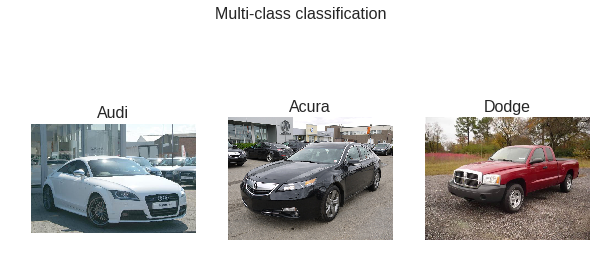

In [16]:
list_paths = [f"{PATH}cars_train/00001.jpg", f"{PATH}cars_train/00002.jpg", f"{PATH}cars_train/00003.jpg"]
titles=["Audi", "Acura", "Dodge"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-class classification")

In [0]:
f_model = resnet50

In [0]:
label_csv = f'{PATH}train.csv'
#compute number of training samples
n = len(list(open(label_csv)))-1
#create list of random idxs of training samples to use as validation set (uses 20% of the training set)
val_idxs = get_cv_idxs(n)

In [0]:
import pandas as pd
label_df = pd.read_csv(label_csv)

In [0]:
label_df.head()

,imagename,label
0,00001.jpg,Audi
1,00002.jpg,Acura
2,00003.jpg,Dodge
3,00004.jpg,Hyundai
4,00005.jpg,Ford


In [0]:
??tfms_from_model

## Transfer Learning without Data Augmentation

Prepare the data, but without data augmentation.

In [0]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

In [0]:
sz = 224

In [0]:
data = get_data(sz)

In [0]:
learn = ConvLearner.pretrained(f_model, data)

Let's use a learning rate finder method to identify a suitable value for our learning rate

In [0]:
lrf = learn.lr_find()

 91%|█████████ | 93/102 [01:29<00:08,  1.04it/s, loss=19.3]

Let us create a plot of how the learning rate was changed with each iteration. 

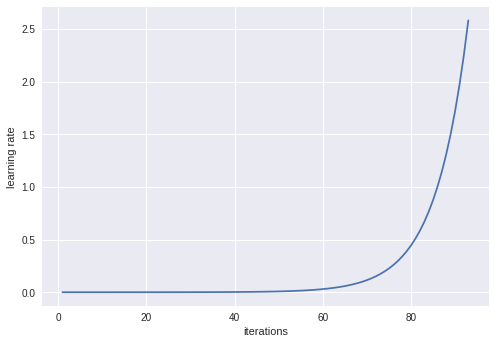

In [0]:
learn.sched.plot_lr()

Let's create a plot of our loss against the learning rate. This should help us choose a suitable value for the learning rate.

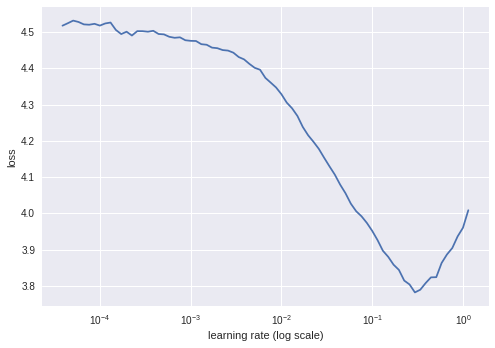

In [0]:
learn.sched.plot()

In [0]:
lr = 0.08

In [0]:
learn.fit(lr, 13)

epoch      trn_loss   val_loss   accuracy   
    0      2.907357   2.132412   0.376536  
    1      2.230345   1.907012   0.44226   
    2      1.974337   1.762299   0.478501  
 36%|███▋      | 37/102 [00:37<01:05,  1.00s/it, loss=1.84]    3      1.755592   1.666075   0.511671  
    4      1.641309   1.5939     0.53317   
    5      1.503562   1.517395   0.551597  
    6      1.412937   1.553601   0.539926  
  2%|▏         | 2/102 [00:07<05:58,  3.58s/it, loss=1.41]    7      1.320076   1.534596   0.550983  
    8      1.256592   1.501917   0.56941   
    9      1.196657   1.480507   0.576167  
 93%|█████████▎| 95/102 [01:32<00:06,  1.03it/s, loss=1.18]    10     1.17134    1.527737   0.566953  
    11     1.087017   1.451586   0.568796  
    12     1.038336   1.487147   0.572482  


[array([1.48715]), 0.5724815724815725]

Let's save our model.

In [0]:
learn.save('224_resnet50_freeze')

In [0]:
learn.load('224_resnet50_freeze')

Let's create a plot of the loss against the mini-batch iterations

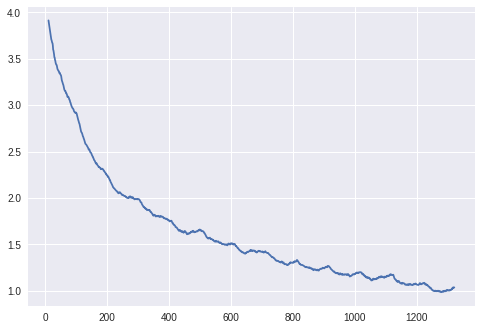

In [0]:
learn.sched.plot_loss()

Now let's upload our model to the Drive before it gets deleted!

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_freeze.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_freeze.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1d12etIYiaYgm4FLBFQ262DMSmryNnvyK


Then download the model from your Drive to your local machine. You never know when you might need to re-use it!

## Model Fine-tuning without Data Augmentation.

In [0]:
learn.unfreeze()

Like before, we try to find a suitable learning rate for the model, but this time when all of the layers are being updated during training.

In [0]:
lrf = learn.lr_find()

 91%|█████████ | 93/102 [02:39<00:15,  1.71s/it, loss=9.33]

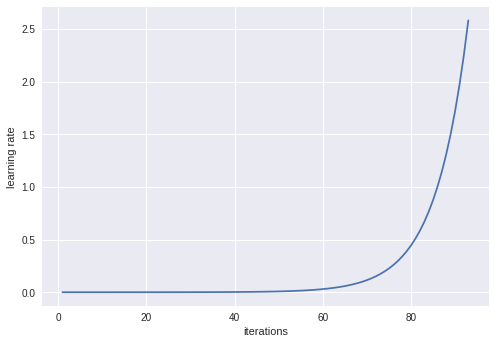

In [0]:
learn.sched.plot_lr()

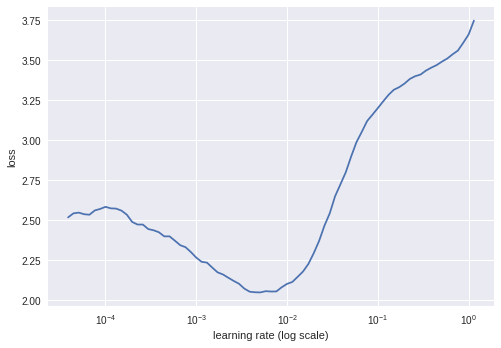

In [0]:
learn.sched.plot()

Here we notice a different behavior than before. Hence, we choose a smaller learning rate.

In [0]:
lr = 0.001

In [0]:
learn.fit(lr, 18)

epoch      trn_loss   val_loss   accuracy   
    0      1.386786   1.249176   0.657248  
    1      0.782595   0.970955   0.714373  
    2      0.513901   0.865997   0.742015  
 35%|███▌      | 36/102 [01:03<01:56,  1.77s/it, loss=0.413]    3      0.329388   0.805661   0.770885  
    4      0.252758   0.75682    0.780098  
    5      0.193781   0.727116   0.793612  
    6      0.153789   0.729249   0.791769  
  0%|          | 0/102 [00:06<?, ?it/s, loss=0.153]    7      0.13031    0.691281   0.79914   
    8      0.110504   0.659273   0.80774   
    9      0.091604   0.653231   0.811425  
 90%|█████████ | 92/102 [02:36<00:17,  1.70s/it, loss=0.0747]    10     0.07544    0.646901   0.820025  
    11     0.06555    0.654633   0.813268  
    12     0.060766   0.627493   0.820639  
    13     0.056761   0.623152   0.826781  
 13%|█▎        | 13/102 [00:25<02:57,  2.00s/it, loss=0.0543]    14     0.052634   0.603666   0.824324  
    15     0.039552   0.615072   0.824324  
    16     0.04027

[array([0.60054]), 0.8329238329238329]

In [0]:
learn.save('224_resnet50_unfreeze')

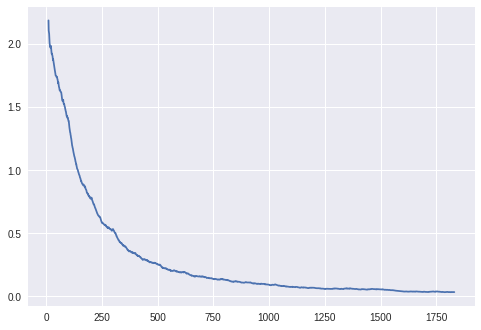

In [0]:
learn.sched.plot_loss()

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_unfreeze.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_unfreeze.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1VMElZEd3pJN8bea6upeRWf28w6raLXYw


## Transfer Learning With Data Augmentation

In [0]:
%reload_ext autoreload
#%autoreload 2
#%matplotlib inline

In [0]:
PATH = "cardata/"

In [0]:
from fastai.conv_learner import *

ModuleNotFoundError: ignored

In [0]:
from fastai.plots import *

In [0]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In [0]:
list_paths = [f"{PATH}cars_train/00001.jpg", f"{PATH}cars_train/00002.jpg", f"{PATH}cars_train/00003.jpg"]
titles=["Audi", "Acura", "Dodge"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-class classification")

In [0]:
f_model = resnet50

In [0]:
label_csv = f'{PATH}train.csv'
#compute number of training samples
n = len(list(open(label_csv)))-1
#create list of random idxs of training samples to use as validation set (uses 20% of the training set)
val_idxs = get_cv_idxs(n)

In [0]:
import pandas as pd
label_df = pd.read_csv(label_csv)

In [0]:
label_df.head()

In [0]:
??tfms_from_model

### Data Augmentation

In [0]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

In [0]:
sz = 224

In [0]:
data = get_data(sz)

In [0]:
def get_augs(aug_data):
  x,_ = next(iter(aug_data.aug_dl))
  return aug_data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs(data) for i in range(6)])

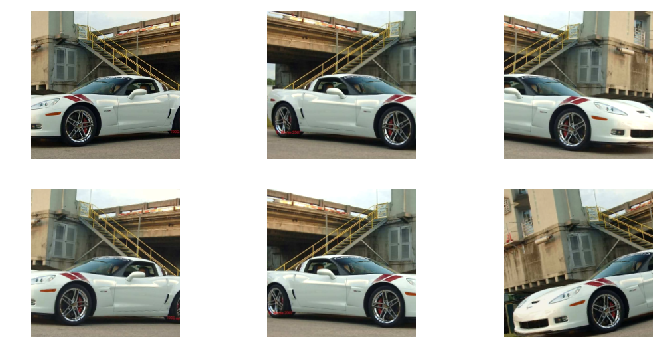

In [0]:
plots(ims, rows=2)

### Model Training

In [24]:
learn = ConvLearner.pretrained(f_model, data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /content/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 32188768.33it/s]


Let's use a learning rate finder method to identify a suitable value for our learning rate

In [0]:
lrf = learn.lr_find()

 91%|█████████ | 93/102 [01:43<00:10,  1.11s/it, loss=17.2]

Let us create a plot of how the learning rate was changed with each iteration. 

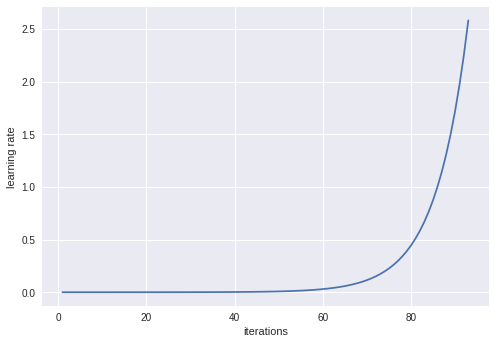

In [0]:
learn.sched.plot_lr()

Let's create a plot of our loss against the learning rate. This should help us choose a suitable value for the learning rate.

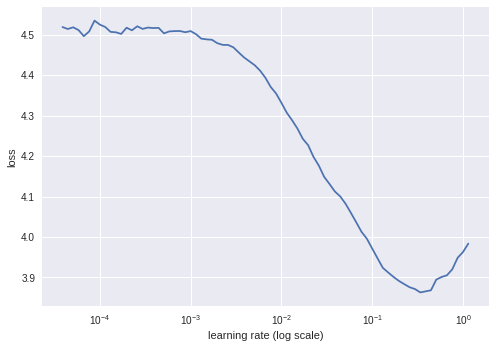

In [0]:
learn.sched.plot()

In [0]:
lr = 0.08

In [0]:
learn.fit(lr, 13)

epoch      trn_loss   val_loss   accuracy   
    0      2.905436   2.203782   0.351351  
    1      2.318374   1.910922   0.433047  
    2      2.068682   1.744277   0.482801  
 36%|███▋      | 37/102 [00:42<01:14,  1.15s/it, loss=1.93]    3      1.934838   1.671471   0.503686  
    4      1.797183   1.622112   0.515356  
    5      1.729694   1.546206   0.536855  
    6      1.619124   1.526251   0.54914   
  2%|▏         | 2/102 [00:10<08:42,  5.22s/it, loss=1.61]    7      1.559311   1.518822   0.535012  
    8      1.501907   1.45965    0.563268  
    9      1.415967   1.426574   0.565111  
 93%|█████████▎| 95/102 [01:43<00:07,  1.09s/it, loss=1.38]    10     1.378723   1.39582    0.590909  
    11     1.34769    1.424696   0.576167  
    12     1.295467   1.367519   0.581695  


[array([1.36752]), 0.5816953314024341]

Let's save our model.

In [0]:
learn.save('224_resnet50_freeze_da')

In [0]:
learn.load('224_resnet50_freeze_da')

Let's create a plot of the loss against the mini-batch iterations

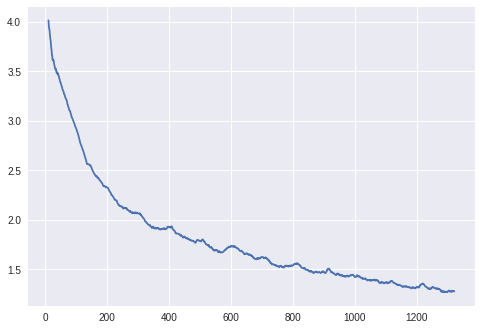

In [0]:
learn.sched.plot_loss()

Now let's upload our model to the Drive before it gets deleted!

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_freeze_da.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_freeze_da.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1-fQSxFyBmCG7v0IBE9TbZZj9DALOSf5M


Then download the model from your Drive to your local machine. You never know when you might need to re-use it!

## Model Fine-tuning with Data Augmentation.

In [0]:
learn.unfreeze()

Like before, we try to find a suitable learning rate for the model, but this time when all of the layers are being updated during training.

In [0]:
lrf = learn.lr_find()

 91%|█████████ | 93/102 [02:43<00:15,  1.76s/it, loss=9.5] 

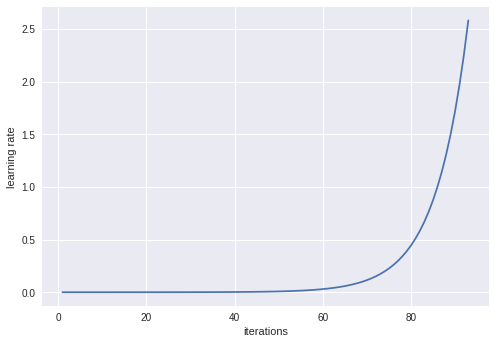

In [0]:
learn.sched.plot_lr()

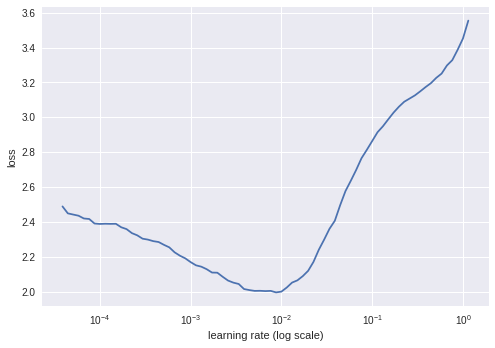

In [0]:
learn.sched.plot()

Here we notice a different behavior than before. Hence, we choose a smaller learning rate.

In [0]:
lr = 0.001

In [0]:
learn.fit(lr, 18)

epoch      trn_loss   val_loss   accuracy   
    0      1.372907   1.044554   0.687961  
    1      0.91873    0.85155    0.7414    
    2      0.683221   0.773679   0.765356  
 35%|███▌      | 36/102 [01:06<02:01,  1.84s/it, loss=0.605]    3      0.530713   0.69751    0.790541  
    4      0.43774    0.684429   0.802211  
    5      0.381629   0.650445   0.804668  
    6      0.30025    0.593555   0.829853  
  0%|          | 0/102 [00:08<?, ?it/s, loss=0.299]    7      0.257714   0.561235   0.829853  
    8      0.230772   0.549765   0.841523  
    9      0.194564   0.526024   0.842752  
 91%|█████████ | 93/102 [02:42<00:15,  1.75s/it, loss=0.17]    10     0.17278    0.522411   0.855651  
    11     0.162453   0.498366   0.855651  
    12     0.132688   0.502007   0.855037  
    13     0.11818    0.50895    0.861179  
 15%|█▍        | 15/102 [00:32<03:07,  2.16s/it, loss=0.119]    14     0.115216   0.482048   0.863636  
    15     0.095777   0.477132   0.864251  
    16     0.089096  

[array([0.45665]), 0.8746928748393235]

In [0]:
learn.save('224_resnet50_unfreeze_da')

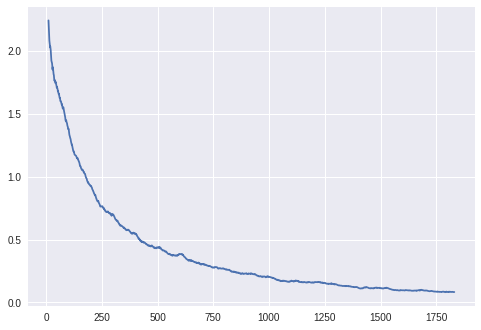

In [0]:
learn.sched.plot_loss()

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_unfreeze_da.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_unfreeze_da.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1HX6quMPBomGXu2RrxPH54NlYO_jVrjpd


## Model Fine-tuning with Data Augmentation and Differential Learning Rates.

In [0]:
learn.load('224_resnet50_freeze_da')

In [0]:
learn.unfreeze()

In [0]:
lr = 0.01

Specify 3 different learning rates for 3 different segments of the model layers (early layers, middle layers, final layers). 

In [0]:
lrs = np.array([lr/9, lr/3, lr])

In [29]:
learn.fit(lrs, 18)

epoch      trn_loss   val_loss   accuracy   
    0      1.526256   1.079038   0.676904  
    1      0.889632   0.76701    0.770885  
    2      0.592807   0.598486   0.818182  
 35%|███▌      | 36/102 [01:00<01:51,  1.68s/it, loss=0.486]    3      0.416457   0.649143   0.811425  
    4      0.321253   0.581795   0.824939  
    5      0.248632   0.503326   0.84828   
    6      0.201413   0.492512   0.855037  
  0%|          | 0/102 [00:06<?, ?it/s, loss=0.201]    7      0.163748   0.51191    0.851966  
    8      0.153581   0.491218   0.859951  
    9      0.122888   0.449807   0.873464  
 90%|█████████ | 92/102 [02:27<00:16,  1.60s/it, loss=0.105]    10     0.103474   0.458158   0.874693  
    11     0.090932   0.451639   0.873464  
    12     0.080065   0.442986   0.880221  
    13     0.074846   0.448091   0.884521  
 13%|█▎        | 13/102 [00:26<03:04,  2.07s/it, loss=0.072]     14     0.069578   0.43585    0.880221  
    15     0.063672   0.408177   0.891892  
    16     0.055675

[array([0.44372]), 0.8839066343459802]

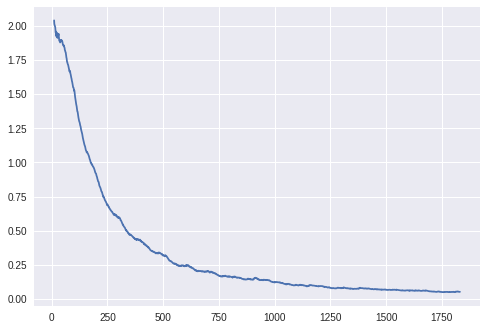

In [30]:
learn.sched.plot_loss()

In [0]:
learn.save('224_resnet50_unfreeze_da_dlrs')

In [0]:
learn.load('224_resnet50_unfreeze_da_dlrs')

For some reason the plot would not show up after training this model. So I had to manually fetch the losses and save a plot as shown below

In [0]:
plt.plot(learn.sched.iterations[10:-5], learn.sched.losses)

In [0]:
plt.savefig('224_unfreeze_da_dlrs.png')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_unfreeze_da_dlrs_Loss.png'})
uploaded.SetContentFile('224_unfreeze_da_dlrs.png')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1kEwpgtnfyVOQs_BY83KaIa_XIBE-sq9O


##Model Fine-tuning with Data Augmentation and Learning Rate Annealing.

### Data Augmentation

In [0]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

In [0]:
sz = 224

In [0]:
data = get_data(sz)

In [0]:
def get_augs(aug_data):
  x,_ = next(iter(aug_data.aug_dl))
  return aug_data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs(data) for i in range(6)])

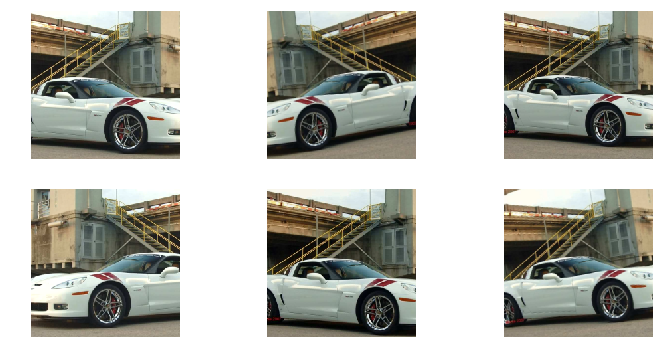

In [0]:
plots(ims, rows=2)

### Upload Pre-trained Model

In [0]:
from google.colab import files
files.upload()

Saving 224_resnet50_freeze_da.h5 to 224_resnet50_freeze_da (1).h5


In [0]:
!mkdir cardata/models && mv 224_resnet50_freeze_da\ \(1\).h5 cardata/models/

In [0]:
!mv cardata/models/224_resnet50_freeze_da\ \(1\).h5 cardata/models/224_resnet50_freeze_da.h5

### Load Pre-trained model

In [0]:
learn = ConvLearner.pretrained(f_model, data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /content/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82305356.32it/s]


In [0]:
learn.load('224_resnet50_freeze_da')

In [0]:
learn.unfreeze()

### Model Training

In [0]:
lr = 0.01

In [0]:
lrs = np.array([lr/9, lr/3, lr])

During model training, we apply learning rate annealing using stochastic gradient descent with restarts (SGDR). This method reduces the value of the learning rate as the model iterates through the mini-batches of an epoch. After each epoch, the learning rate is reset to it's original value and annealing begins again. Here, the annealing follows a cosine functional form that we will visualize after we finish training.

In [0]:
learn.fit(lrs, 18, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.477932   1.093551   0.664005  
    1      1.023741   0.820134   0.751843  
    2      0.705026   0.723591   0.793612  
 35%|███▌      | 36/102 [01:02<01:54,  1.73s/it, loss=0.613]    3      0.551924   0.629831   0.805283  
    4      0.422466   0.588111   0.823096  
    5      0.352107   0.555632   0.83231   
    6      0.29774    0.51713    0.845823  
  0%|          | 0/102 [00:09<?, ?it/s, loss=0.297]    7      0.240143   0.502306   0.847666  
    8      0.192463   0.501803   0.84828   
    9      0.177827   0.477724   0.856265  
 91%|█████████ | 93/102 [02:30<00:14,  1.62s/it, loss=0.16]    10     0.159753   0.44954    0.867322  
    11     0.131946   0.430658   0.869165  
    12     0.131492   0.443877   0.864251  
    13     0.113393   0.428767   0.874079  
 15%|█▍        | 15/102 [00:29<02:53,  1.99s/it, loss=0.103]    14     0.108854   0.44597    0.863636  
    15     0.098513   0.441918   0.875921  
    16     0.080748  

[array([0.43591]), 0.8814496315960803]

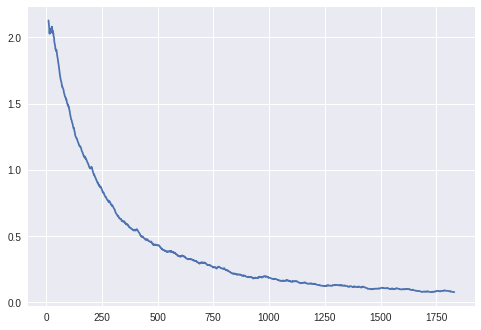

In [0]:
learn.sched.plot_loss()

In [0]:
learn.save('224_resnet50_unfreeze_da_dlrs_lra')

In [0]:
learn.load('224_resnet50_unfreeze_da_dlrs_lra')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_unfreeze_da_dlrs_lra.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_unfreeze_da_dlrs_lra.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 15aRbligvj4-EpyhGnH2skVW0keTZaMyj


##Model Fine-tuning with Data Augmentation, Learning Rate Annealing, and Differential Annealing Periods

### Data Augmentation

In [0]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

In [0]:
sz = 224

In [0]:
data = get_data(sz)

In [0]:
def get_augs(aug_data):
  x,_ = next(iter(aug_data.aug_dl))
  return aug_data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs(data) for i in range(6)])

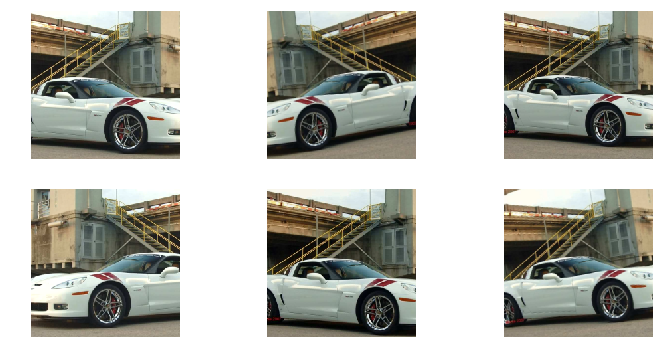

In [0]:
plots(ims, rows=2)

### Upload Pre-trained Model

In [0]:
from google.colab import files
files.upload()

Saving 224_resnet50_freeze_da.h5 to 224_resnet50_freeze_da (1).h5


In [0]:
!mkdir cardata/models && mv 224_resnet50_freeze_da\ \(1\).h5 cardata/models/

In [0]:
!mv cardata/models/224_resnet50_freeze_da\ \(1\).h5 cardata/models/224_resnet50_freeze_da.h5

### Load Pre-trained model

In [0]:
learn = ConvLearner.pretrained(f_model, data)

In [0]:
learn.load('224_resnet50_freeze_da')

In [0]:
learn.unfreeze()

### Model Training

In [0]:
lr = 0.01

In [0]:
lrs = np.array([lr/9, lr/3, lr])

During model training, we apply learning rate annealing using stochastic gradient descent with restarts (SGDR). This method reduces the value of the learning rate as the model iterates through the mini-batches of an epoch. After each epoch, the learning rate is reset to it's original value and annealing begins again. Here, the annealing follows a cosine functional form that we will visualize after we finish training. We also introduce cycle_mult=2, which effectively extends the period of the cosine function by a factor of 2 after each cycle. 

In [0]:
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.495787   1.080726   0.678747  
    1      1.020058   0.823995   0.760442  
    2      0.629296   0.682829   0.802826  
 35%|███▌      | 36/102 [01:02<01:55,  1.75s/it, loss=0.562]    3      0.613564   0.692818   0.786855  
    4      0.437123   0.579006   0.82801   
    5      0.271949   0.501891   0.853808  
    6      0.203742   0.490358   0.855037  
  0%|          | 0/102 [00:08<?, ?it/s, loss=0.205]    7      0.26793    0.540592   0.847666  
    8      0.256097   0.569086   0.841523  
    9      0.184713   0.507192   0.857494  
 90%|█████████ | 92/102 [02:30<00:16,  1.64s/it, loss=0.141]    10     0.137664   0.426552   0.878378  
    11     0.104968   0.41239    0.884521  
    12     0.080051   0.391921   0.887592  
    13     0.068111   0.38542    0.89312   
 14%|█▎        | 14/102 [00:28<02:59,  2.04s/it, loss=0.0695]    14     0.064864   0.385893   0.888206  
    15     0.104177   0.488745   0.864251  
    16     0.11609 

[array([0.36615]), 0.899262898823553]

In [0]:
learn.sched.plot_lr()

In [0]:
plt.savefig("lr_plotv2.png")

In [0]:
plt.savefig('224_unfreeze_da_dlrs_lra_mult_LRvsIterv2.png')

In [0]:
log_preds = learn.predict(is_test=True)

In [0]:
probs = np.exp(log_preds)

In [0]:
accuracy_np(probs, test_y)

0.8987688098495212

In [0]:
tta_log_preds, _y = learn.TTA(is_test=True)

In [0]:
tta_probs = np.mean(np.exp(tta_log_preds),0)

In [0]:
accuracy_np(tta_probs, test_y)

0.9131948762591717

In [0]:
learn.save('224_resnet50_unfreeze_da_dlrs_lra_mult')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!ls

224_resnet50_freeze_da.h5		      cardata	      losses.npy
224_unfreeze_da_dlrs_lra_mult_LRvsIter.png    car_devkit.tgz  loss_plot.png
224_unfreeze_da_dlrs_lra_mult_LRvsIterv2.png  cars_test.tgz   lr_plot.png
224_unfreeze_da_dlrs_lra_mult.png	      cars_train.tgz
224_unfreeze_da_dlrs.png		      datalab


In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'lr_plotv2.png'})
uploaded.SetContentFile('lr_plotv2.png')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1irHIkmKIuekEQvrzTHi4xWavexLmuN7F


##Model Fine-tuning with Data Augmentation, Learning Rate Annealing, and Differential Annealing Periods.

### Data Augmentation

In [0]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

In [0]:
sz = 224

In [0]:
data = get_data(sz)

In [0]:
def get_augs(aug_data):
  x,_ = next(iter(aug_data.aug_dl))
  return aug_data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs(data) for i in range(6)])

In [0]:
plots(ims, rows=2)

In [0]:
learn.load('224_resnet50_freeze_da')

In [0]:
learn.unfreeze()

In [0]:
lr = 0.01

During model training, we apply learning rate annealing using stochastic gradient descent with restarts (SGDR). This method reduces the value of the learning rate as the model iterates through the mini-batches of an epoch. After each epoch, the learning rate is reset to it's original value and annealing begins again. Here, the annealing follows a cosine functional form that we will visualize after we finish training.

In [0]:
lrs = np.array([lr/9, lr/3, lr])

In [0]:
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

NameError: ignored

In [0]:
learn.save('224_resnet50_unfreeze_da_dlrs')

In [0]:
learn.load('224_resnet50_unfreeze_da_dlrs')

In [0]:
learn.sched.plot_loss()

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': '224_resnet50_unfreeze_da_dlrs.h5'})
uploaded.SetContentFile('cardata/models/'+'224_resnet50_unfreeze_da_dlrs.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1KmY6xxSkA8dPIyleM_OH3_3jpEAnoMUl


# Testing Our Model

Upload your saved model from your local machine to the host.

In [1]:
from google.colab import files
files.upload()

Saving 224_resnet50_freeze_da.h5 to 224_resnet50_freeze_da (1).h5


In [0]:
!mv 224_resnet50_freeze_da\ \(1\).h5 224_resnet50_freeze_da.h5

Move the saved model to the appropriate folder

In [0]:
!mv 224_resnet50_freeze_da.h5 cardata/models/

In [10]:
!ls cardata/models

224_resnet50_freeze_da.h5


Import libraries

In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
from fastai.conv_learner import *

In [48]:
from fastai.plots import *

In [49]:
PATH = "data/cars/"

Display a couple of images from the test set to check that everything's fine

In [50]:
def get_1st(path): return glob(f'{path}/*.*')[0]

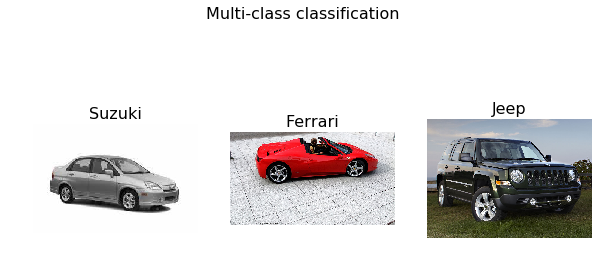

In [51]:
list_paths = [f"{PATH}cars_test/00001.jpg", f"{PATH}cars_test/00002.jpg", f"{PATH}cars_test/00003.jpg"]
titles=[test_imgs_labels[0][1], test_imgs_labels[1][1], test_imgs_labels[2][1]]
plots_from_files(list_paths, titles=titles, maintitle="Multi-class classification")

Specify the model. In this case it is the ResNet-50 model.

In [52]:
f_model = resnet50

Create a list of indexes to be used to create a validation set from the training set during model training

In [53]:
label_csv = f'{PATH}train.csv'
#compute number of training samples
n = len(list(open(label_csv)))-1
#create list of random idxs of training samples to use as validation set (uses 20% of the training set)
val_idxs = get_cv_idxs(n)

Use pandas to create a data frame of our data set using the .csv file. Visualize the data sample names and their labels

In [54]:
import pandas as pd
label_df = pd.read_csv(label_csv)

In [55]:
label_df.head()

,imagename,label
0,00001.jpg,Audi
1,00002.jpg,Acura
2,00003.jpg,Dodge
3,00004.jpg,Hyundai
4,00005.jpg,Ford


In [56]:
#simple function to grab the data sets, resize images to sz, perform image transformations, 
#and create a validation set
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'cars_train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='cars_test')

Specify the size of the input images to our model

In [57]:
sz = 224

In [58]:
data = get_data(sz)

Load our saved model

In [59]:
learn = ConvLearner.pretrained(f_model, data)

In [94]:
learn.load('224_resnet50_unfreeze_da_dlrs_lra_mult')

Create an array of labels for the test set samples (test_y) to be able to compute the final accuracy

In [61]:
test_imgs = {}

In [62]:
for img in test_imgs_labels:
  img_fname = img[0]
  img_label = img[1]
  img_label_idx = label_encodings[img_label]
  test_imgs[img_fname] = img_label_idx

In [63]:
test_imgs['00436.jpg']

26

In [64]:
for i, fname in enumerate(data.test_ds.fnames):
  img_fname = fname.split('/')[1] #grab image filename
  test_y[i] = test_imgs[img_fname]

In [95]:
log_preds_val = learn.predict()

In [96]:
probs_val = np.exp(log_preds_val)

In [97]:
accuracy_np(probs_val, data.val_y)

0.8992628992628993

Compute the model predictions on the test set. This outputs the logarithm of the probabilities for each class.

In [98]:
log_preds_test = learn.predict(is_test=True)

Compute the probabilities of the model predictions on the test set.

In [99]:
probs_test = np.exp(log_preds_test)

Compute the overall accuracy on the test set.

In [100]:
accuracy_np(probs_test, test_y)

0.8987688098495212

Compute the model predictions on the test set using test-time augmentation (TTA). This creates 4 augmented version of each test image, and computes prediction on each of them (i.e. computes 5 prediction values for each test image)

In [101]:
tta_log_preds, y_tta = learn.TTA(is_test=True)

Compute the average of the 5 predictions for each test image.

In [102]:
tta_log_pred_avg = np.mean(tta_log_preds,0)

In [103]:
tta_log_pred_avg.shape

(8041, 49)

Compute the probabilities of the model predictions on the test set using TTA.

In [104]:
tta_probs = np.exp(np.mean(tta_log_preds,0))

In [105]:
tta_probs.shape

(8041, 49)

Compute the overall accuracy of the model on the test set using TTA.

In [106]:
accuracy_np(tta_probs, test_y)

0.9148115905981843

# Inference on User-Input

In [148]:
trn_tfms, val_tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_side_on, max_zoom=1.1)

In [158]:
im = val_tfms(open_image(f'{PATH}test_imgs/mercedes_coupe.jpg'))

In [159]:
im.shape

(3, 224, 224)

In [160]:
learn.precompute=False

In [161]:
prediction = learn.predict_array(im[None])

In [162]:
np.argmax(prediction)

4

In [163]:
for label in label_encodings:
    if(label_encodings[label]==np.argmax(prediction)):
        print(label)

BMW
